In [1]:
import jax, numpyro
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.distributions import (
    Normal, Uniform, TruncatedNormal, Beta, LogNormal
)
from corner import corner

from eggman.emulator import Emulator
from eggman.distributions import Salpeter

numpyro.set_platform("cpu")
numpyro.set_host_device_count(10)
rng = random.PRNGKey(0)
numpyro.enable_x64()

In [2]:
emulator = Emulator()

In [3]:
log_zx_sun = np.log10(0.0181)
log_teff_sun = np.log10(5772)

In [4]:
bounds = jnp.arange(0.0, 5.0)
widths = jnp.diff(bounds)
new_bounds = jnp.array([0.0, 0.3, 0.6, 0.7, 1.0])
new_widths = jnp.diff(new_bounds)

def generator(a, b, c):
    return lambda x: a + b * (x - c)

funclist = [generator(l, w/nw, nl) for w, nw, l, nl in zip(widths, new_widths, bounds[:-1], new_bounds[:-1])]
    
def evol_phase(x):
    return jnp.piecewise(
        x,
        [(lower <= x) & (x < upper) for lower, upper in zip(new_bounds[:-1], new_bounds[1:])],
        funclist,
    )

(0.0, 4.0)

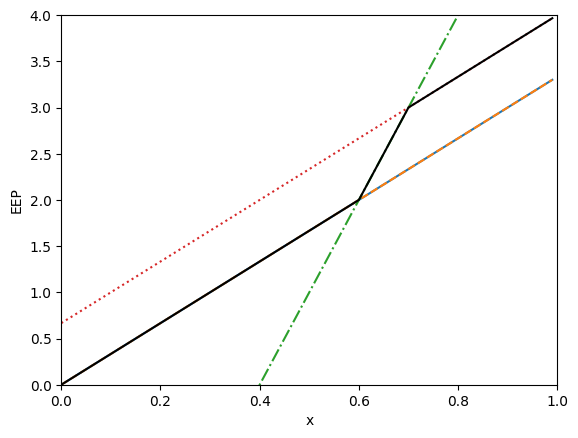

In [5]:
x = np.arange(0, 1, 0.01)

for ls, f in zip(['solid', 'dashed', 'dashdot', 'dotted'], funclist):
    plt.plot(x, f(x), ls=ls)
y = evol_phase(x)

plt.plot(x, y, "k")
plt.xlabel("x")
plt.ylabel("EEP")
plt.xlim(0, 1)
plt.ylim(0, 4)

In [12]:
low_log_z, high_log_z = -2.8, -1.4
low_y, high_y = 0.22, 0.32
low_mass, high_mass = 0.7, 2.3
low_a, high_a = 1.3, 2.7

def log_luminosity(log_teff, log_radius):
    return 2 * log_radius + 4 * (log_teff - log_teff_sun)

def hydrogen(y, z):
    return 1 - y - z

def metallicity(y, z):    
    return jnp.log10(z / hydrogen(y, z)) - log_zx_sun

def heavy_elements(y, mh):
    return (1 - y) / (10**-(mh + log_zx_sun) + 1)

def mean_helium_z(z, y0, dydz):
    return y0 + dydz * z

def mean_helium_mh(mh, y0, dydz):
    f = dydz / (10**-(mh + log_zx_sun) + 1)
    return (y0 + f) / (1 + f)

def mean_a_mlt(mass, a1, dadm):
    return a1 + dadm * (mass - 1)

def hierarchical_model(num_stars, lum=None, teff=None, mh=None, sigma_lum=0.01, sigma_teff=50.0, sigma_mh=0.05):
    dydz = numpyro.sample("DY_DZ", TruncatedNormal(1.5, 1.0, low=0.0, high=2.5))
    y0 = numpyro.sample("Y_0", Normal(0.247, 0.001))
    sigma_y = numpyro.sample("sigma_Y", LogNormal(jnp.log(0.01), 0.5))
    
    dadm = numpyro.sample("Da_Dm", TruncatedNormal(-0.3, 0.3, low=-0.5, high=0.0))
    a1 = numpyro.sample("a_1", Normal(2.0, 0.1))
    sigma_a = numpyro.sample("sigma_a", LogNormal(jnp.log(0.1), 0.5))
    
    with numpyro.plate("star", num_stars):
        x = numpyro.sample("x", Uniform(0.0, 0.99))
        eep = numpyro.deterministic("EEP", evol_phase(x))

        mass = numpyro.sample("mass", Salpeter(2.35, low=low_mass, high=high_mass))
        
        if mh is None:
            _mh = numpyro.sample("M_H", Uniform(-0.9, 0.5))
        else:
            _mh = numpyro.sample("M_H", TruncatedNormal(mh, sigma_mh, low=-0.9, high=0.5))

#         log_z = numpyro.sample("log_Z", Uniform(low_log_z, high_log_z))
#         z = numpyro.deterministic("Z", 10**log_z)
#         mu_y = mean_helium_z(z, y0, dydz)
        
        mu_y = mean_helium_mh(_mh, y0, dydz)
        y = numpyro.sample("Y", TruncatedNormal(mu_y, sigma_y, low=low_y, high=high_y))

        z = numpyro.deterministic("Z", heavy_elements(y, _mh))
        log_z = numpyro.deterministic("log_Z", jnp.log10(z))

        mu_a = mean_a_mlt(mass, a1, dadm)
        # when precision issue encountered, this just doesn't truncate!
        a_mlt = numpyro.sample("a_MLT", TruncatedNormal(mu_a, sigma_a, low=low_a, high=high_a))

    xx = jnp.stack([eep, mass, y, log_z, a_mlt], axis=-1)
    yy = emulator(xx)

    log_lum = log_luminosity(yy[:, 1], yy[:, 2])

    numpyro.sample("lum", Normal(10**log_lum, sigma_lum), obs=lum)
    numpyro.sample("Teff", Normal(10**yy[:, 1], sigma_teff), obs=teff)
#     numpyro.sample("M_H", TruncatedNormal(metallicity(y, z), sigma_mh, low=-0.9, high=0.5), obs=mh)

    log_age = numpyro.deterministic("log_age", yy[:, 0])
    age = numpyro.deterministic("age", 10**log_age)

In [13]:
rng, key = random.split(rng)
prior_predictive = Predictive(hierarchical_model, num_samples=10000)
prior_samples = prior_predictive(key, 1)

In [14]:
data = az.from_numpyro(prior=prior_samples)
data

Inference data with groups:
	> prior

In [15]:
truths = {
    "DY_DZ": 1.5,
    "Y_0": 0.247,
    "sigma_Y": 0.01,
}

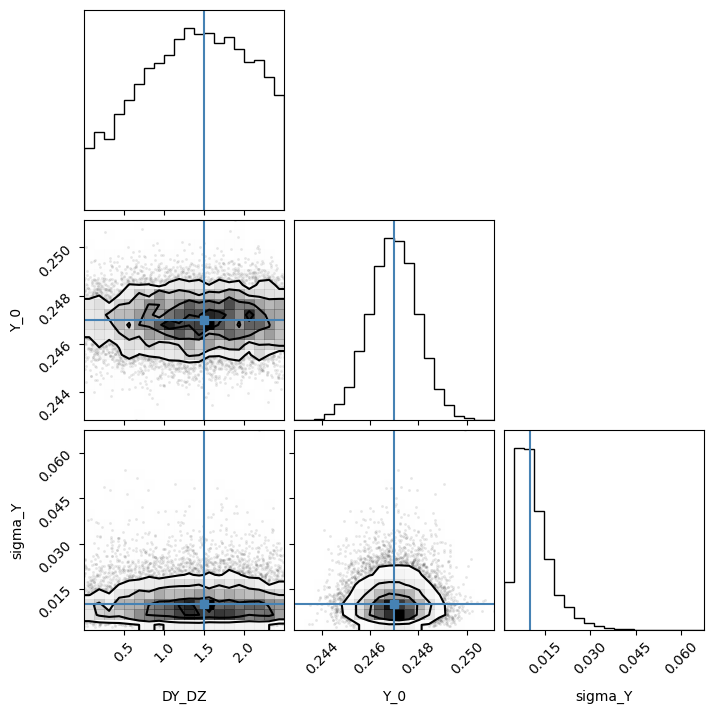

In [16]:
fig = corner(data, group="prior", var_names=["DY_DZ", "Y_0", "sigma_Y"], truths=truths)

In [17]:
truths.update({
    "Da_Dm": -0.3,
    "a_1": 2.0,
    "sigma_a": 0.1
})

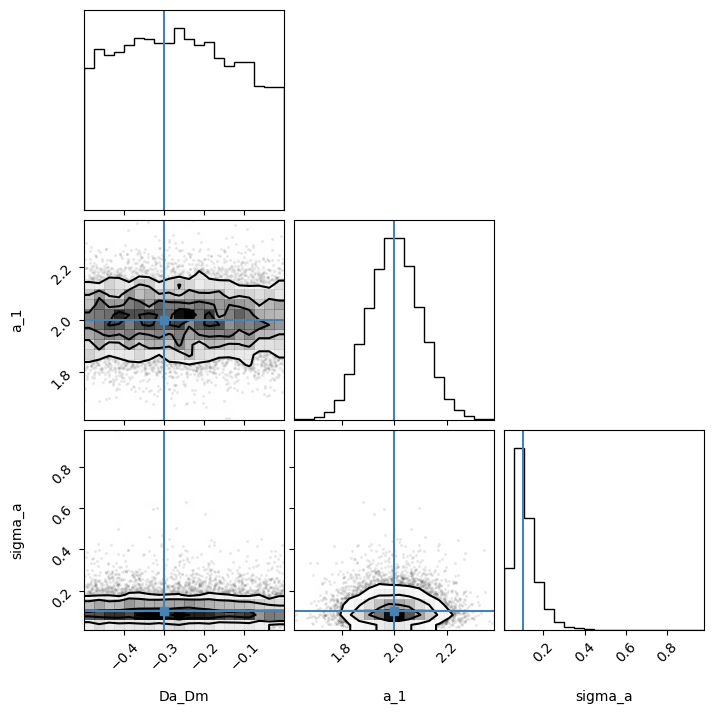

In [18]:
fig = corner(data, group="prior", var_names=["Da_Dm", "a_1", "sigma_a"], truths=truths)

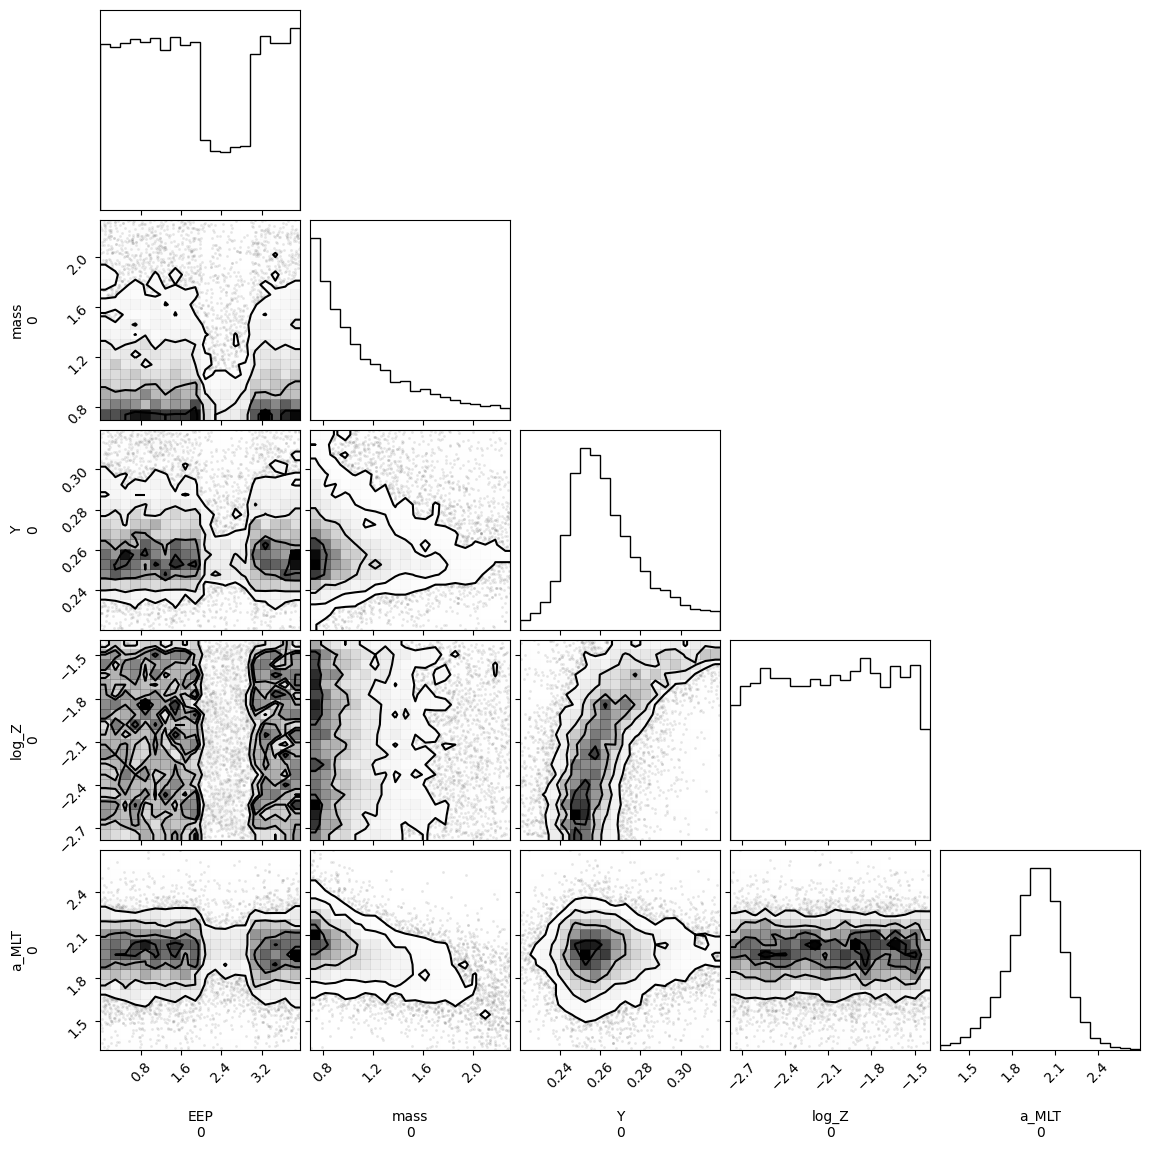

In [19]:
fig = corner(data, group="prior", var_names=["EEP", "mass", "Y", "log_Z", "a_MLT"])

In [20]:
data.prior.mass.sel(chain=0).squeeze()

<xarray.DataArray 'mass' (draw: 10000)>
array([0.83130519, 1.00958952, 0.87664417, ..., 0.81098945, 0.95812496,
       1.29694167])
Coordinates:
    chain       int64 0
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
    mass_dim_0  int64 0

In [21]:
import matplotlib.colors as mcolors

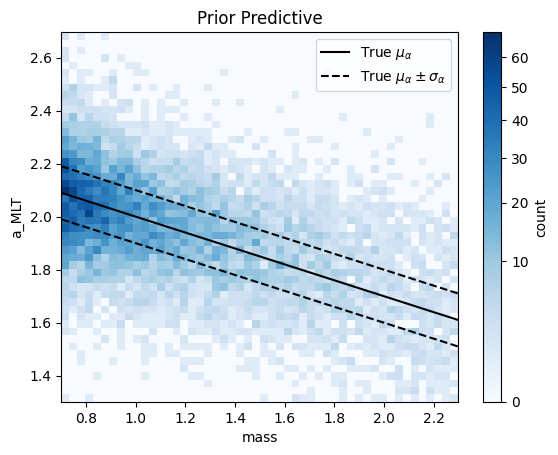

In [22]:
mass = np.linspace(low_mass, high_mass)
mu_a = mean_a_mlt(mass, truths["a_1"], truths["Da_Dm"])

fig, ax = plt.subplots()
*_, im = ax.hist2d(
    data.prior.mass.sel(chain=0).squeeze(), 
    data.prior.a_MLT.sel(chain=0).squeeze(), 
    bins=50, 
#     cmin=1,
    cmap="Blues",
    norm=mcolors.PowerNorm(1/2)
)
# ax.plot(data.prior.mass.sel(chain=0), data.prior.a_MLT.sel(chain=0), ".", zorder=0)

ax.plot(mass, mu_a, "k-", label=r"True $\mu_\alpha$")
ax.plot(mass, mu_a-truths["sigma_a"], "k--", label=r"True $\mu_\alpha\pm\sigma_\alpha$")
ax.plot(mass, mu_a+truths["sigma_a"], "k--")

ax.set_xlabel("mass")
ax.set_ylabel("a_MLT")

fig.colorbar(im, label="count")
ax.legend()
ax.set_title("Prior Predictive");

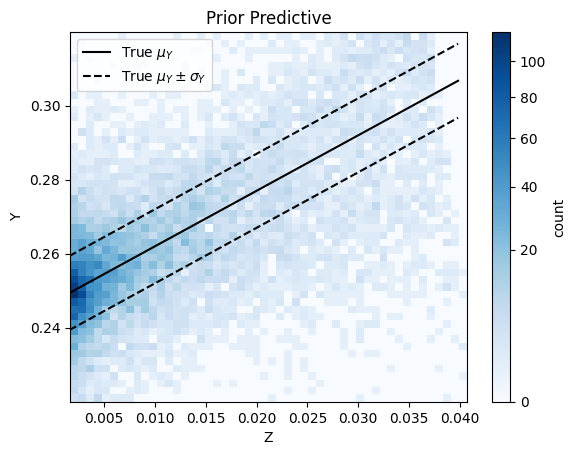

In [24]:
z = np.logspace(low_log_z, high_log_z)
mu_y = mean_helium_z(z, truths["Y_0"], truths["DY_DZ"])

fig, ax = plt.subplots()
*_, im = ax.hist2d(
    data.prior.Z.sel(chain=0).squeeze(), 
    data.prior.Y.sel(chain=0).squeeze(), 
    bins=50, 
#     cmin=1,
    cmap="Blues",
    norm=mcolors.PowerNorm(1/2)
)
# ax.plot(data.prior.Z.sel(chain=0), data.prior.Y.sel(chain=0), ".")
ax.plot(z, mu_y, "k-", label=r"True $\mu_Y$")
ax.plot(z, mu_y-truths["sigma_Y"], "k--", label=r"True $\mu_Y\pm\sigma_Y$")
ax.plot(z, mu_y+truths["sigma_Y"], "k--")

ax.set_xlabel("Z")
ax.set_ylabel("Y")

fig.colorbar(im, label="count")

ax.legend()
ax.set_title("Prior Predictive");

In [25]:
from jax.scipy.special import ndtri, ndtr, log_ndtr

In [26]:
def truncnorm_cdf(x, loc=0, scale=1, low=-float("inf"), high=float("inf")):
    alpha = (low - loc) / scale
    beta = (high - loc) / scale
    phi_alpha = ndtr(alpha)
    z = ndtr(beta) - phi_alpha
    
    eta = (x - loc) / scale
    return (ndtr(eta) - phi_alpha) / z

def truncnorm_icdf(y, loc=0, scale=1, low=-float("inf"), high=float("inf")):
    alpha = (low - loc) / scale
    beta = (high - loc) / scale
    phi_alpha = ndtr(alpha)
    z = ndtr(beta) - phi_alpha
    return loc + scale * ndtri(z * y + phi_alpha)

As the distribution gets further from the truncated region, we reach precision limits.

We need a better solution for this.

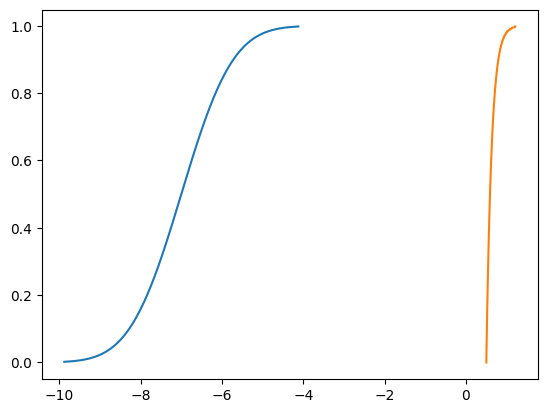

In [27]:
loc = -7
scale = 1

y = np.linspace(0, 1, 501)
x = truncnorm_icdf(y, loc=loc, scale=scale, low=0.5, high=1.5)
plt.plot(loc + scale * ndtri(y), y)
plt.plot(x, y)

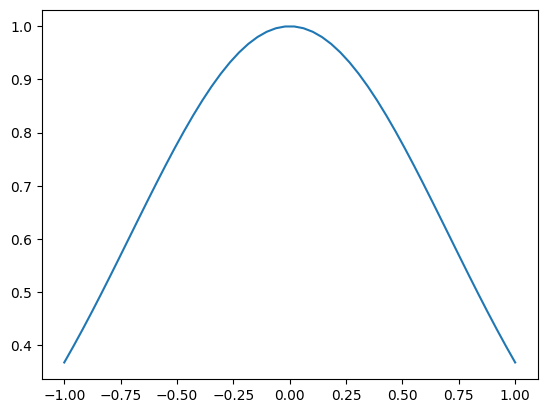

In [28]:
x = np.linspace(-1, 1)
plt.plot(x, np.exp(-x**2))

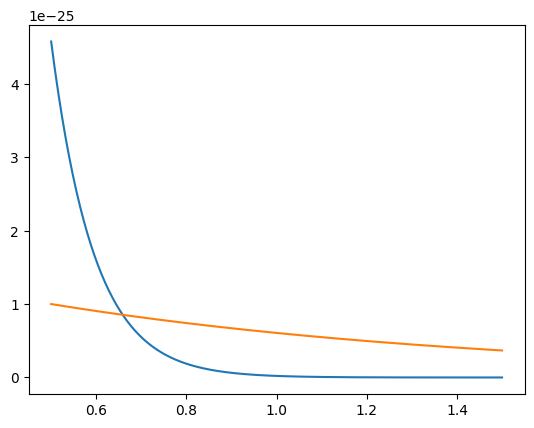

In [29]:
x = np.linspace(0.5, 1.5, 501)
plt.plot(x, jax.scipy.stats.norm.pdf(x, loc=-10))
plt.plot(x, 1e-25*np.exp(-x+0.5))

Just scales the whole thing. Just need to make sure draw from 0 to 1

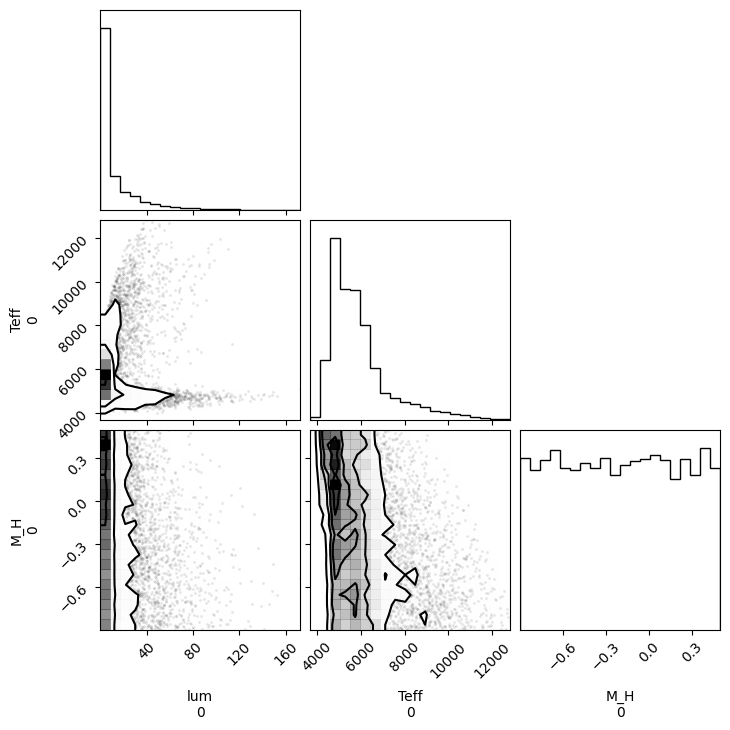

In [30]:
fig = corner(data, group="prior", var_names=["lum", "Teff", "M_H"])

In [32]:
data.prior.sel(chain=0, draw=0)

<xarray.Dataset>
Dimensions:        (EEP_dim_0: 1, M_H_dim_0: 1, Teff_dim_0: 1, Y_dim_0: 1,
                    Z_dim_0: 1, a_MLT_dim_0: 1, age_dim_0: 1, log_Z_dim_0: 1,
                    log_age_dim_0: 1, lum_dim_0: 1, mass_dim_0: 1, x_dim_0: 1)
Coordinates: (12/14)
    chain          int64 0
    draw           int64 0
  * EEP_dim_0      (EEP_dim_0) int64 0
  * M_H_dim_0      (M_H_dim_0) int64 0
  * Teff_dim_0     (Teff_dim_0) int64 0
  * Y_dim_0        (Y_dim_0) int64 0
    ...             ...
  * age_dim_0      (age_dim_0) int64 0
  * log_Z_dim_0    (log_Z_dim_0) int64 0
  * log_age_dim_0  (log_age_dim_0) int64 0
  * lum_dim_0      (lum_dim_0) int64 0
  * mass_dim_0     (mass_dim_0) int64 0
  * x_dim_0        (x_dim_0) int64 0
Data variables: (12/18)
    DY_DZ          float64 1.663
    Da_Dm          float64 -0.1391
    EEP            (EEP_dim_0) float64 0.5558
    M_H            (M_H_dim_0) float64 0.3547
    Teff           (Teff_dim_0) float64 4.952e+03
    Y              (Y_dim_0) float64 0.3094
    ...             ...
    log_age        (log_age_dim_0) float64 9.606
    lum            (lum_dim_0) float64 0.3331
    mass           (mass_dim_0) float64 0.8313
    sigma_Y        float64 0.01139
    sigma_a        float64 0.1517
    x              (x_dim_0) float64 0.1667
Attributes:
    created_at:                 2023-08-15T16:18:38.725660
    arviz_version:              0.15.1
    inference_library:          numpyro
    inference_library_version:  0.12.1

In [38]:
lum, sigma_lum = 1., 0.03
teff, sigma_teff = 5772.0, 75.
mh, sigma_mh = 0.0, 0.1

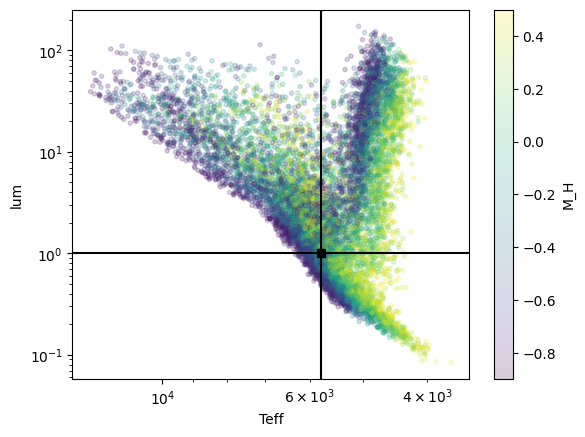

In [39]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "M_H"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

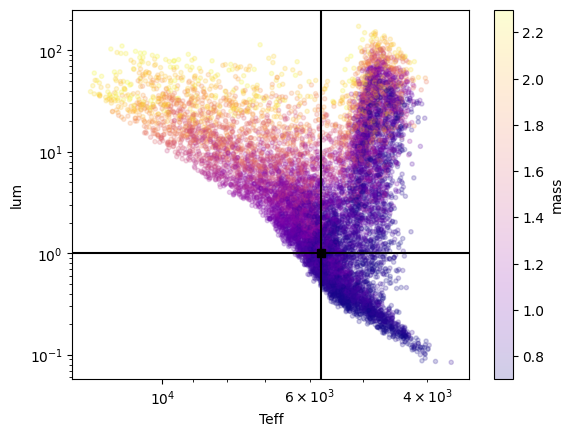

In [40]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "mass"
cmap = "plasma"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

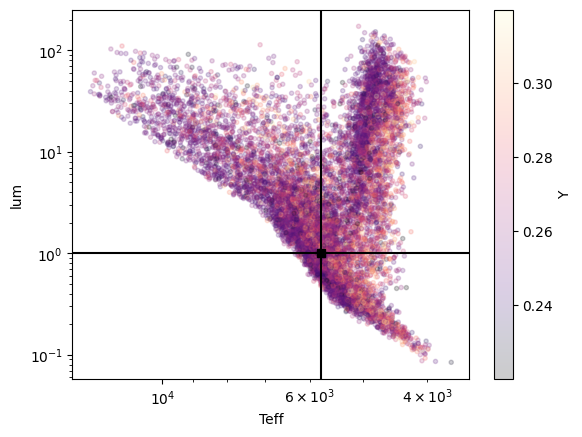

In [41]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "Y"
cmap = "magma"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

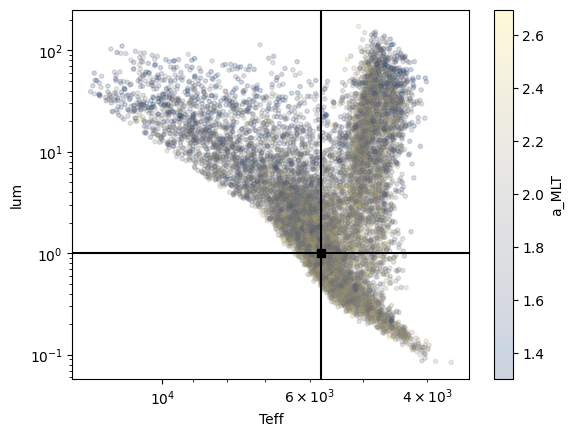

In [42]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "a_MLT"
cmap = "cividis"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

In [44]:
nuts = NUTS(hierarchical_model, init_strategy=numpyro.infer.init_to_median,
#             dense_mass=[("log_Z", "a_MLT")],  # huge degenerecy between these
            dense_mass=True  # helps a lot
            )
mcmc = MCMC(nuts, num_warmup=3000, num_samples=1000, num_chains=10)

It is very important that luminosity uncertainty is reasonable. If too low, struggles to sample. This could be emulator noise.

In [46]:
rng, key = random.split(rng)
mcmc.run(key, 1, lum=lum, teff=teff, mh=mh,
         sigma_lum=sigma_lum, sigma_teff=sigma_teff, sigma_mh=sigma_mh)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [47]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     DY_DZ      1.36      0.64      1.39      0.39      2.44   5921.51      1.00
     Da_Dm     -0.26      0.14     -0.27     -0.50     -0.07   7744.89      1.00
    M_H[0]      0.00      0.10      0.00     -0.15      0.16   4038.88      1.00
      Y[0]      0.27      0.01      0.26      0.24      0.29   4130.49      1.00
       Y_0      0.25      0.00      0.25      0.25      0.25  14113.73      1.00
       a_1      2.00      0.10      2.00      1.84      2.17   5156.88      1.00
  a_MLT[0]      2.01      0.16      2.01      1.75      2.27   2180.97      1.00
   mass[0]      0.97      0.07      0.98      0.85      1.08   1411.56      1.00
   sigma_Y      0.01      0.01      0.01      0.00      0.02   4347.51      1.00
   sigma_a      0.11      0.06      0.10      0.03      0.19   3642.75      1.00
      x[0]      0.26      0.13      0.28      0.04      0.45   1541.45      1.00

Number of divergences: 73


In [48]:
data += az.from_numpyro(mcmc)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

In [51]:
rng, key = random.split(rng)
post_predictive = Predictive(hierarchical_model, posterior_samples=mcmc.get_samples())
post_samples = post_predictive(key, 1, mh=mh, sigma_mh=sigma_mh)

In [52]:
data += az.from_numpyro(posterior_predictive=post_samples)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

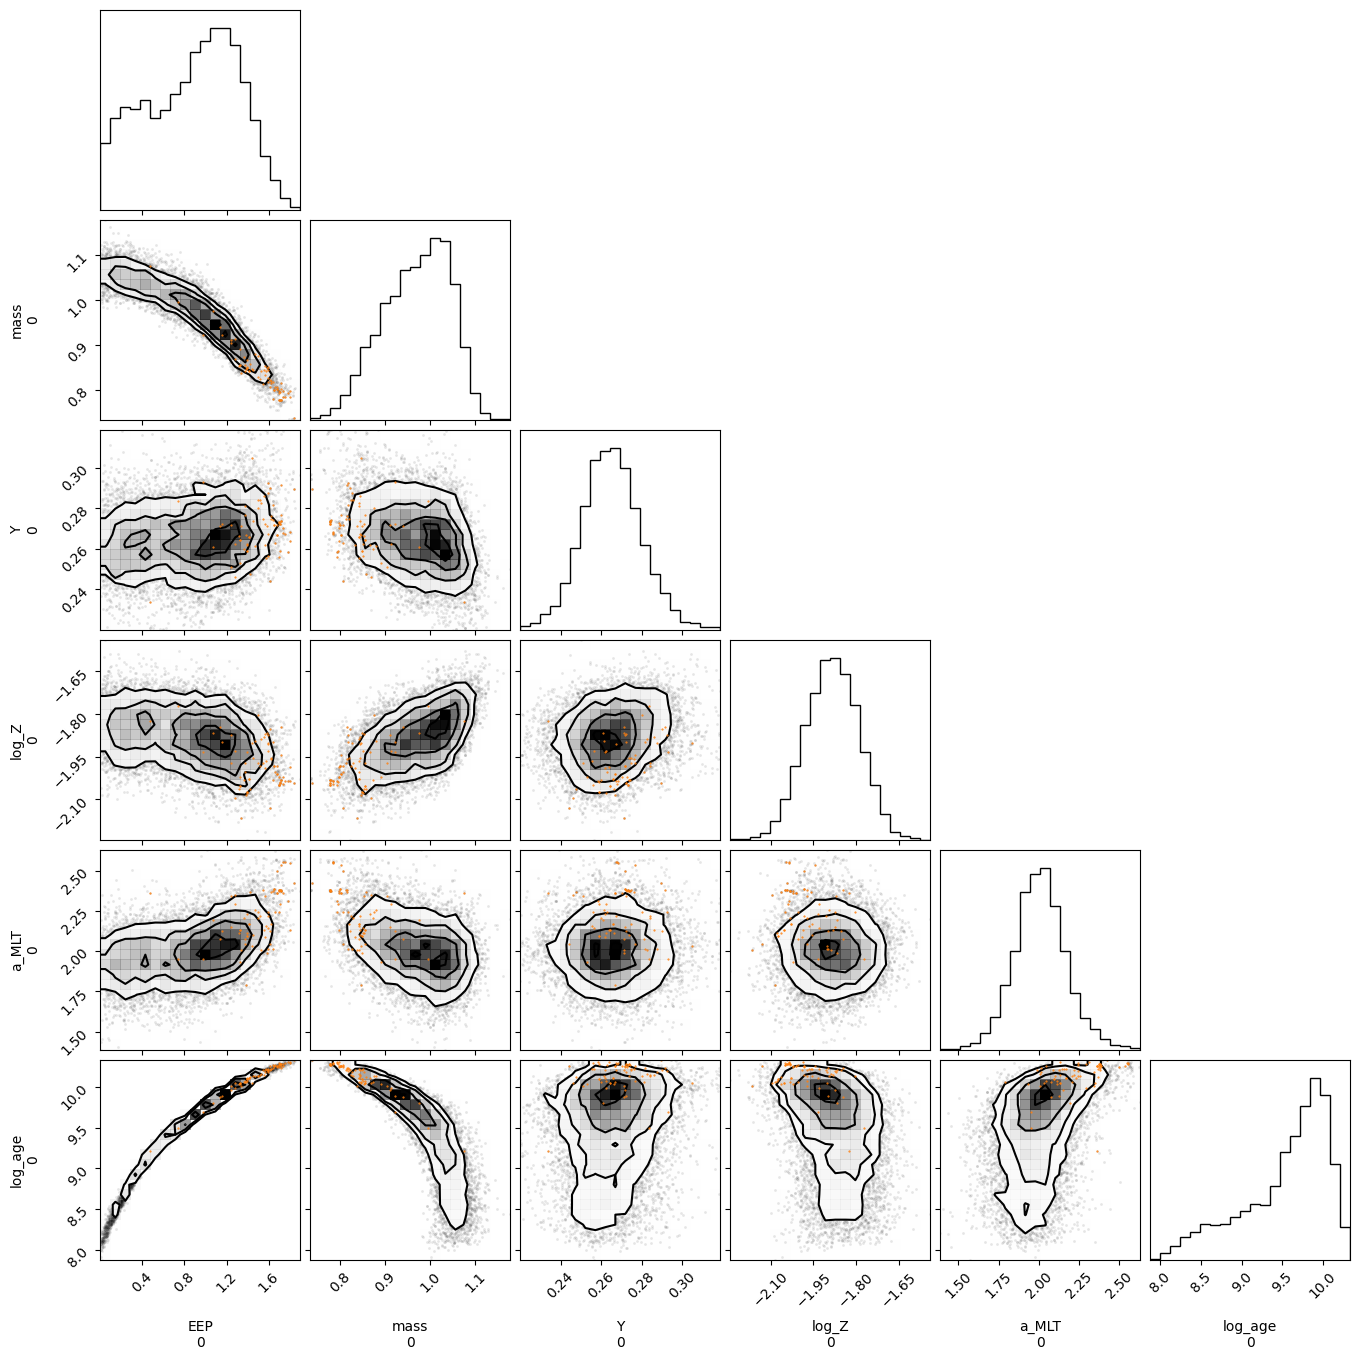

In [53]:
var_names = [
    "EEP", 
    "mass", 
    "Y", 
    "log_Z", 
    "a_MLT", 
    "log_age",
]
fig = corner(data, var_names=var_names, divergences=True)

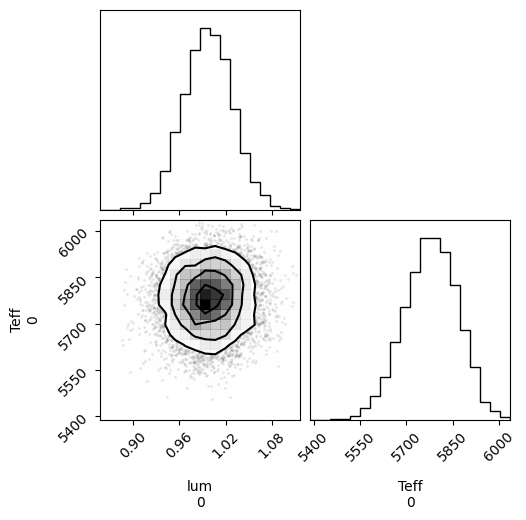

In [55]:
fig = corner(data, group="posterior_predictive", var_names=["lum", "Teff"])

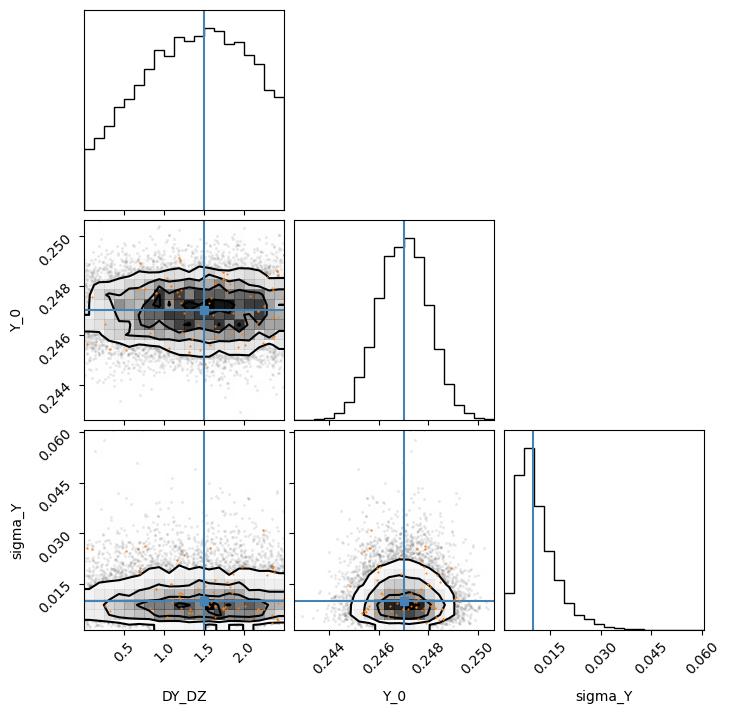

In [58]:
fig = corner(data, group="posterior", var_names=["DY_DZ", "Y_0", "sigma_Y"], truths=truths, divergences=True)

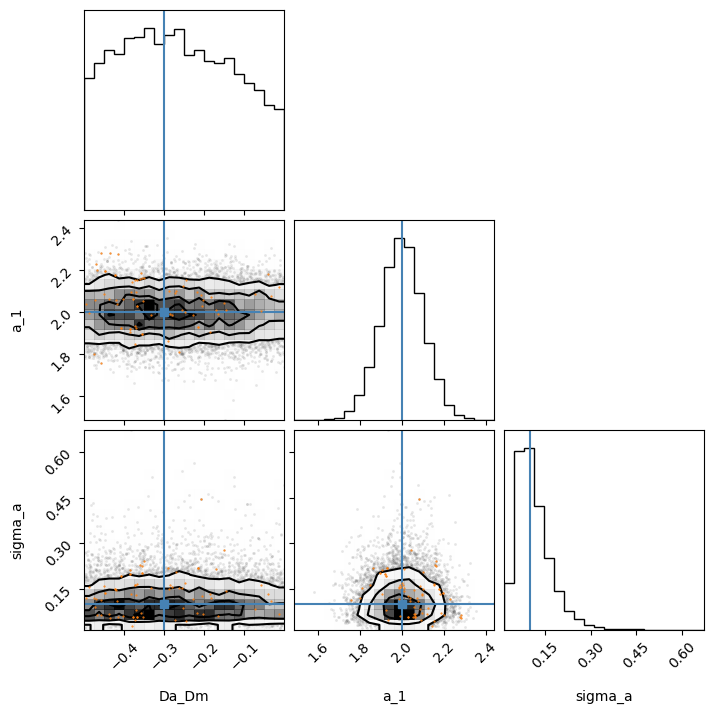

In [59]:
fig = corner(data, group="posterior", var_names=["Da_Dm", "a_1", "sigma_a"], truths=truths, divergences=True)